# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

#### The overall process of building the solution is as follows:
- We perform similar options for Fixed Length and Variable Length sequences.

    ##### Fixed Length Sequences:

    ##### Simple:
    - We start with a custom Pytorch dataset which will process the data and return the input and output tensors.If the sequences are of varying lengths, we will pad them with zeros to make them of the same length.
    - We will use the Pytorch DataLoader to load the data in batches and using the padding collate function to pad the sequences at batch level.
    - We will use a simple LSTM model `CpGCounter` to predict the next token in the sequence which is a basic model with an LSTM layer and a linear layer.
    - We have training loop and evaluation loop to train and evaluate the model and we have used optimizer `AdamW` loss `MSELoss` and lr scheduler `ReduceLROnPlateau`
    - We have used `mse` and `rmse` as metrics to evaluate the model.
    - We have used `early stopping` to stop the training if the model is not improving.
    
    ##### Advanced:
    - We will use a more complex model `CpGCounterAdvanced` which has an LSTM layer, a linear layer and and regularization layer `Dropout` to prevent overfitting.
    - We will use `AdamW` optimizer, `MSELoss` loss and `ReduceLROnPlateau` lr scheduler and also gradient clipping to prevent exploding gradients and gradient scaler and autocast
    - We have used `mse` and `rmse` as metrics to evaluate the model.
    - We have used `early stopping` to stop the training if the model is not improving.
    



In [2]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random
import os

In [3]:
# DO NOT CHANGE HERE (Original as per the assignment)
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(13)


# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int = 128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i : i + 2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers
alphabet = "NACGT"
dna2int = {a: i for a, i in zip(alphabet, range(5))}
int2dna = {i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [4]:
# we stick to the original function signature
def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    print(f"The total length of X_dna_seqs_train is {len(X_dna_seqs_train)}")
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X 
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    # step2
    temp = ["".join(list(intseq_to_dnaseq(seq))) for seq in X_dna_seqs_train]
    # temp is basically the a list of DNA sequences and each sequence is a string
    # step3
    y_dna_seqs = [count_cpgs(seq) for seq in temp]
    # y_dna_seqs is basically the count of CGs in each DNA sequence
    print(f"The total length of y_dna_seqs is {len(y_dna_seqs)}")

    return X_dna_seqs_train, y_dna_seqs


train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

The total length of X_dna_seqs_train is 2048
The total length of y_dna_seqs is 2048
The total length of X_dna_seqs_train is 512
The total length of y_dna_seqs is 512


In [5]:
dna2int

{'N': 0, 'A': 1, 'C': 2, 'G': 3, 'T': 4}

In [6]:
# def count_23_pairs(lst, n1=3, n2=4):
#     count = 0
#     for i in range(len(lst) - 1):
#         if lst[i] == n1 and lst[i + 1] == n2:
#             count += 1
#     return count

In [7]:
# train_y[9], count_23_pairs(train_x[9])

In [8]:
# each sequence has a length of 128 and the total number of sequences is 2048 and 512 for train and test respectively
print(
    min(map(len, train_x)),
    max(map(len, train_x)),
    min(map(len, test_x)),
    max(map(len, test_x)),
)
print(len(train_x), len(test_x))

128 128 128 128
2048 512


##### -----------------Hyperparameters----------------- #####

In [9]:
batch_size = 16
embedding_dim = 64
hidden_size = 256
num_layers = 2
dropout = 0.2
learning_rate = 0.001
num_epochs = 100
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stop_patience = 10

In [10]:
vocab_size = len(dna2int)
print(vocab_size)
print(device)

5
cuda


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import Tuple, List
import time
from sklearn.model_selection import train_test_split
from torch.amp import GradScaler, autocast

##### -------------------------Pytorch Custom Dataset and Dataloader-----------------------

In [12]:
class CPGDataset(Dataset):
    def __init__(self, sequences, labels):
        """
        Initialize the dataset with sequences and labels (CpG counts) as input arguments and store them as attributes.

        Parameters:
        - sequences (List[List[int]]): List of integer-encoded DNA sequences.
        - labels (List[int]): List of CpG counts corresponding to each sequence.

        Returns:
        - None
        """
        self.sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        """
        Return the number of sequences in the dataset.
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Retrieve a sequence and its label by index.
        """
        return self.sequences[idx], self.labels[idx]

    @staticmethod
    def collate_fn(batch):
        """
        Custom collate function to pad sequences dynamically and return a batch of sequences and labels.
        """
        sequences, labels = zip(*batch)
        padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
        return padded_sequences, torch.tensor(labels, dtype=torch.float32)

In [13]:
# pytorch standard dataset
train_dataset = CPGDataset(train_x, train_y)
val_dataset = CPGDataset(test_x, test_y)

In [14]:
# each iteration of the dataset will return a list of sequences and a labels
x, y = next(iter(train_dataset))
print(x.shape, y.shape)

torch.Size([128]) torch.Size([])


In [15]:
# pytorch standard dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=CPGDataset.collate_fn,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=CPGDataset.collate_fn,
)

In [16]:
# each iteration of the dataloader will return a batch of sequences and labels
for x_batch, y_batch in train_dataloader:
    print(x_batch.shape, y_batch.shape)
    break

for x_batch, y_batch in val_dataloader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16])


Key Notes:
* We are using a collate function to pad the sequences dynamically which will be used in the dataloader to return a padded batch of sequences and labels.
* Even if the sequences are of different lengths, the collate function will pad them to the same length.
* The sequences are stored as a list of tensors and the labels are stored as a tensor.

##### Basic LSTM model #####

In [17]:
class CpGCounter(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        """
        Initialize the CpGCounter model with the given hyperparameters and layers.

        Parameters:
        - vocab_size (int): Number of unique tokens in the input sequences.
        - embedding_dim (int): Dimension of the embedding layer.
        - hidden_size (int): Dimension of the hidden state in the LSTM layer.
        - num_layers (int): Number of LSTM layers.
        - dropout (float): Dropout rate to apply between LSTM layers.

        Returns:
        None
        """
        super(CpGCounter, self).__init__()
        # Embedding layer to convert integer-encoded sequences to embeddings of fixed size (embedding_dim)
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=0
        )  # input: (batch_size, seq_len), output: (batch_size, seq_len, embedding_dim)
        # LSTM layer to process the embeddings and capture sequential information (hidden_size)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0
        )  # input: (batch_size, seq_len, embedding_dim), output: (batch_size, seq_len, hidden_size)
        # Fully connected layer to predict the number of CpG sites
        self.fc = nn.Linear(
            hidden_size, 1
        )  # input: (batch_size, seq_len, hidden_size), output: (batch_size, seq_len, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass of the CpGCounter model.

        Parameters:
        - x (torch.Tensor): Input sequences with shape (batch_size, seq_len).

        Returns:
        - torch.Tensor: Predicted CpG counts for each sequence in the batch.
        """

        assert (
            torch.max(x).item() < self.embedding.num_embeddings
        ), "Index out of range!"
        # Embed the input sequences
        embedded = self.embedding(x)
        # Process the embeddings with an LSTM layer
        lstm_output, _ = self.lstm(embedded)
        # we only take the last hidden state
        lstm_output = lstm_output[
            :, -1, :
        ]  # shape is (batch_size, hidden_size) and we only take the last hidden state of the sequence
        # Predict the number of CpG sites
        output = self.fc(lstm_output)
        return self.relu(output)

##### Helper Functions #####
* Training loop: A function to train the model for one epoch.
* Evaluation loop: A function to evaluate the model on the validation set.
* Training function: A function to train the model for multiple epochs.
* Checkpoint functions: Functions to save and load model checkpoints.
* Inference function: A function to get predictions from the model.

In [18]:
def training_loop(model, dataloader, device, optimizer, criterion):
    """
    Runs one training epoch.

    Parameters:
    - model (nn.Module): PyTorch model to train.
    - dataloader (DataLoader): Training DataLoader.
    - device (torch.device): CPU or GPU.
    - optimizer (torch.optim.Optimizer): Optimizer.
    - criterion (nn.Module): Loss function.

    Returns:
    - avg_loss (float): Average loss over dataset.
    - avg_mae (float): Average MAE over dataset.
    - avg_rmse (float): Average RMSE over dataset.
    """
    model.train()
    total_loss, total_mae, total_rmse = 0.0, 0.0, 0.0
    num_batches = len(dataloader)

    for inputs, labels in dataloader:
        inputs, labels = (
            inputs.to(device),
            labels.to(device),
        )

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Compute batch-wise metrics
        batch_mae = mean_absolute_error(
            labels.cpu().numpy(), outputs.detach().cpu().numpy()
        )
        batch_rmse = (
            mean_squared_error(labels.cpu().numpy(), outputs.detach().cpu().numpy())
            ** 0.5
        )

        total_loss += loss.item()
        total_mae += batch_mae
        total_rmse += batch_rmse

    return total_loss / num_batches, total_mae / num_batches, total_rmse / num_batches

In [19]:
def validation_loop(model, dataloader, device, criterion):
    """
    Runs one validation epoch.

    Parameters:
    - model (nn.Module): PyTorch model to evaluate.
    - dataloader (DataLoader): Validation DataLoader.
    - device (torch.device): CPU or GPU.
    - criterion (nn.Module): Loss function.

    Returns:
    - avg_loss (float): Average loss over dataset.
    - avg_mae (float): Average MAE over dataset.
    - avg_rmse (float): Average RMSE over dataset.
    """
    model.eval()
    total_loss, total_mae, total_rmse = 0.0, 0.0, 0.0
    num_batches = len(dataloader)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = (
                inputs.to(device),
                labels.to(device),
            )
            outputs = model(inputs).squeeze()

            loss = criterion(outputs, labels)

            # Compute batch-wise metrics
            batch_mae = mean_absolute_error(labels.cpu().numpy(), outputs.cpu().numpy())
            batch_rmse = (
                mean_squared_error(labels.cpu().numpy(), outputs.cpu().numpy()) ** 0.5
            )

            total_loss += loss.item()
            total_mae += batch_mae
            total_rmse += batch_rmse

    return total_loss / num_batches, total_mae / num_batches, total_rmse / num_batches

In [20]:
def save_checkpoint(
    epoch, model, optimizer, scheduler, best_val_loss, save_path="best_cpg_model.pth"
):
    """
    Saves the model, optimizer, and scheduler state for training resumption.

    Parameters:
    - epoch (int): Current epoch number.
    - model (nn.Module): PyTorch model to save.
    - optimizer (torch.optim.Optimizer): Optimizer to save.
    - scheduler (torch.optim.lr_scheduler): Scheduler to save.
    - best_val_loss (float): Best validation loss achieved.
    - save_path (str): Path to save the checkpoint.

    """
    checkpoint = {
        "epoch": epoch + 1,  # Save next epoch to resume correctly
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "best_val_loss": best_val_loss,
    }
    torch.save(checkpoint, save_path)
    print(f"Model checkpoint saved at {save_path}")


def load_checkpoint(
    model, optimizer, scheduler, device, save_path="best_cpg_model.pth"
):
    """
    Loads a saved checkpoint to resume training.

    Parameters:
    - model (nn.Module): PyTorch model to load the state_dict into.
    - optimizer (torch.optim.Optimizer): Optimizer to load the state_dict into.
    - scheduler (torch.optim.lr_scheduler): Scheduler to load the state_dict into.
    - device (torch.device): CPU or GPU.
    - save_path (str): Path to the saved checkpoint.
    
    """
    checkpoint = torch.load(save_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    best_val_loss = checkpoint["best_val_loss"]

    print(
        f"Loaded checkpoint from {save_path}, resuming from epoch {checkpoint['epoch']} with best validation loss: {best_val_loss:.4f}"
    )
    return model, optimizer, scheduler, checkpoint["epoch"], best_val_loss

In [21]:
def train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=25,
    patience=5,
    save_path="best_cpg_model.pth",
    lr=0.001,
    weight_decay=1e-4,
    resume=False,
):
    """
    Trains an LSTM model with validation and early stopping. Supports resuming training.

    Parameters:
    - model: LSTM model.
    - train_loader: Training DataLoader.
    - val_loader: Validation DataLoader.
    - device: CPU or GPU.
    - epochs: Max training epochs.
    - patience: Early stopping patience.
    - save_path: Path to save the best model.
    - lr: Initial learning rate.
    - weight_decay: L2 regularization weight.
    - resume: Whether to resume training from the last checkpoint.

    Returns:
    - Best trained model.
    """
    # initialize model and optimizer and scheduler and criterion and best_val_loss and start_epoch
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.1,
        patience=2,
    )

    best_val_loss = float("inf")
    start_epoch = 0

    # Load checkpoint if resuming
    if resume and os.path.exists(save_path):
        try:
            model, optimizer, scheduler, start_epoch, best_val_loss = load_checkpoint(
                model, optimizer, scheduler, device, save_path
            )
        except FileNotFoundError:
            print("No checkpoint found. Starting training from scratch.")

    else:
        print("Starting training from scratch.")

    no_improvement = 0
    start_time = time.time()

    try:
        for epoch in range(start_epoch, epochs):
            train_loss, train_mae, train_rmse = training_loop(
                model, train_loader, device, optimizer, criterion
            )
            val_loss, val_mae, val_rmse = validation_loop(
                model, val_loader, device, criterion
            )

            # Scheduler step
            if epoch > 0:
                scheduler.step(val_loss)

            # Print results
            print(
                f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Train RMSE: {train_rmse:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}"
            )

            # Save best model checkpoint
            if val_loss < best_val_loss:
                print(
                    f"New best validation loss: {val_loss:.4f} (previous best: {best_val_loss:.4f})"
                )
                best_val_loss = val_loss
                no_improvement = 0
                save_checkpoint(
                    epoch, model, optimizer, scheduler, best_val_loss, save_path
                )
            else:
                no_improvement += 1
                print(f"No improvement, patience left: {patience - no_improvement}")

            # Early stopping
            if no_improvement >= patience:
                print(f"Early Stopping Triggered after epoch {epoch+1}")
                break

    except KeyboardInterrupt:
        print("Training Interrupted! Saving last checkpoint...")
        save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, save_path)

    print(f"Training Completed in {(time.time() - start_time):.2f} seconds")

    # Load the best model before returning
    model, optimizer, scheduler, _, _ = load_checkpoint(
        model, optimizer, scheduler, device, save_path
    )
    return model

In [22]:
def predict_cpgs_from_dna(
    model_path: str,
    dna_sequence: str,
    dna2int: dict,
    embedding_dim,
    hidden_size,
    num_layers,
    dropout,
    device,
    model_class=CpGCounter,
):
    """
    Predict CpG count from a human DNA string.

    Parameters:
    - model_path: Path to trained LSTM model.
    - dna_sequence: Human-readable DNA string.
    - dna2int: Dictionary mapping DNA bases to integer values.
    - embedding_dim: Dimension of embedding layer.
    - hidden_size: Size of LSTM hidden state.
    - num_layers: Number of LSTM layers.
    - dropout: Dropout rate.
    - device: The device ('cpu' or 'cuda') for inference.
    - model_class: Model class to use for inference.

    Returns:
    - Predicted CpG count (rounded to 2 decimal places).
    """

    # Check if the model checkpoint exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model checkpoint not found at {model_path}")

    # Load Model
    vocab_size = len(dna2int)
    model = model_class(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
    )

    # Load the trained model checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)  # Move model to the correct device
    model.eval()

    # Convert DNA string to integer sequence
    int_sequence = [
        dna2int.get(base, 0) for base in dna_sequence
    ]  # Map bases to integers
    # print(int_sequence)
    int_tensor = (
        torch.tensor(int_sequence, dtype=torch.long).unsqueeze(0).to(device)
    )  # Move to same device

    # Inference
    with torch.no_grad():
        predicted_count = model(int_tensor).squeeze().item()  # Ensure it's a scalar

    return round(predicted_count, 2)

In [23]:
# Train the model
new_model = CpGCounter(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
)
print(new_model)

CpGCounter(
  (embedding): Embedding(5, 64, padding_idx=0)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)


In [24]:
best_model = train_model(
    new_model,
    train_dataloader,
    val_dataloader,
    device,
    epochs=num_epochs,
    patience=stop_patience,
    save_path="best_cpg_model.pth",
    lr=learning_rate,
    weight_decay=weight_decay,
)

Starting training from scratch.
Epoch 1/100, Train Loss: 6.5828, Train MAE: 1.9894, Train RMSE: 2.3758, Val Loss: 4.1894, Val MAE: 1.6242, Val RMSE: 2.0227
New best validation loss: 4.1894 (previous best: inf)
Model checkpoint saved at best_cpg_model.pth
Epoch 2/100, Train Loss: 4.2484, Train MAE: 1.6438, Train RMSE: 2.0328, Val Loss: 4.2041, Val MAE: 1.6323, Val RMSE: 2.0264
No improvement, patience left: 9
Epoch 3/100, Train Loss: 4.2388, Train MAE: 1.6415, Train RMSE: 2.0304, Val Loss: 4.2629, Val MAE: 1.6582, Val RMSE: 2.0411
No improvement, patience left: 8
Epoch 4/100, Train Loss: 4.2322, Train MAE: 1.6407, Train RMSE: 2.0290, Val Loss: 4.2086, Val MAE: 1.6358, Val RMSE: 2.0279
No improvement, patience left: 7
Epoch 5/100, Train Loss: 4.2037, Train MAE: 1.6381, Train RMSE: 2.0226, Val Loss: 4.5284, Val MAE: 1.7263, Val RMSE: 2.1048
No improvement, patience left: 6
Epoch 6/100, Train Loss: 4.2467, Train MAE: 1.6510, Train RMSE: 2.0343, Val Loss: 4.1592, Val MAE: 1.5879, Val RMSE: 

In [25]:
# Test Example create a 128 length DNA sequence with 5 CG sites
test_dna = test_x[91]
test_dna = "".join(list(intseq_to_dnaseq(test_dna)))
print(test_dna)
print(count_cpgs(test_dna))

# Predict the CpG count from the test DNA sequence
predicted_cpgs = predict_cpgs_from_dna(
    "best_cpg_model.pth",
    test_dna,
    dna2int,
    embedding_dim,
    hidden_size,
    num_layers,
    dropout,
    device,
    model_class=CpGCounter,
)

print(f"DNA: {test_dna} \n🔹 Predicted CpG Count: {predicted_cpgs}")

TGGANNANAAATNNTGGANCTGNCTNNGTCGTNCGATANGTCNNATTTCNCTGGNANNNTGTGGTTTCCGGCGACNTGAGGATGGTCCGGCTCGNAGACNAANCGGGGNNCATGNGANCANNCNNANN
7
DNA: TGGANNANAAATNNTGGANCTGNCTNNGTCGTNCGATANGTCNNATTTCNCTGGNANNNTGTGGTTTCCGGCGACNTGAGGATGGTCCGGCTCGNAGACNAANCGGGGNNCATGNGANCANNCNNANN 
🔹 Predicted CpG Count: 6.97


##### Advanced Concepts 
* New Model Architecture with Regularization and bilstm layer
* Gradient Clipping
* Mixed Precision Training and Gradient Scaling

In [79]:
class CpGCounterAdvanced(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        """
        Initialize the CpGCounterAdvanced model with an embedding layer, LSTM layer, batch normalization, and fully connected layer with ReLU activation.

        Parameters:
        - vocab_size (int): Number of unique tokens in the vocabulary.
        - embedding_dim (int): Dimension of the embedding layer.
        - hidden_size (int): Dimension of the LSTM hidden state.
        - num_layers (int): Number of LSTM layers.
        - dropout (float): Dropout rate.

        Returns:
        - None
        """
        super(CpGCounterAdvanced, self).__init__()
        # Embedding layer to convert integer-encoded sequences to embeddings of fixed size (embedding_dim)
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=0
        )  # input: (batch_size, seq_len), output: (batch_size, seq_len, embedding_dim)
        # LSTM layer to process the embeddings and capture sequential information (hidden_size) and bidirectional
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
        )  # input: (batch_size, seq_len, embedding_dim), output: (batch_size, seq_len, hidden_size)
        # add batch normalization 2 additional hidden states
        self.batch_norm = nn.BatchNorm1d(
            hidden_size * 2
        )  # input: (batch_size, seq_len, hidden_size), output: (batch_size, seq_len, hidden_size)
        # Fully connected layer to predict the number of CpG sites and ReLU activation
        self.fc = nn.Linear(
            hidden_size * 2, 1
        )  # input: (batch_size, seq_len, hidden_size), output: (batch_size, seq_len, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass of the CpGCounterAdvanced model with batch normalization and bidirectional LSTM.
        """
        assert (
            torch.max(x).item() < self.embedding.num_embeddings
        ), "Index out of range!"
        # Embed the input sequences
        embedded = self.embedding(x)
        # Process the embeddings with an LSTM layer
        lstm_output, _ = self.lstm(embedded)
        # we only take the last hidden state
        lstm_output = lstm_output[
            :, -1, :
        ]  # shape is (batch_size, hidden_size) and we only take the last hidden state of the sequence
        # Batch normalization
        lstm_output = self.batch_norm(lstm_output)
        # Predict the number of CpG sites
        output = self.fc(lstm_output)
        return self.relu(output)

In [27]:
def training_loop_advanced(
    model, dataloader, device, optimizer, criterion, grad_scaler
):
    """
    Runs one training epoch.

    Parameters:
    - model (nn.Module): PyTorch model to train.
    - dataloader (DataLoader): Training DataLoader.
    - device (torch.device): CPU or GPU.
    - optimizer (torch.optim.Optimizer): Optimizer.
    - criterion (nn.Module): Loss function.
    - grad_scaler (GradScaler): Gradient scaler for mixed precision training.

    Returns:
    - avg_loss (float): Average loss over dataset.
    - avg_mae (float): Average MAE over dataset.
    - avg_rmse (float): Average RMSE over dataset.
    """
    model.train()
    total_loss, total_mae, total_rmse = 0.0, 0.0, 0.0
    num_batches = len(dataloader)

    for inputs, labels in dataloader:
        inputs, labels = (
            inputs.to(device),
            labels.to(device),
        )

        optimizer.zero_grad()

        # Mixed precision training context manager
        with autocast("cuda" if device.type == "cuda" else "cpu"):
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_scaler.step(optimizer)
        grad_scaler.update()

        # Compute batch-wise metrics
        batch_mae = mean_absolute_error(
            labels.cpu().numpy(), outputs.detach().cpu().numpy()
        )
        batch_rmse = (
            mean_squared_error(labels.cpu().numpy(), outputs.detach().cpu().numpy())
            ** 0.5
        )

        total_loss += loss.item()
        total_mae += batch_mae
        total_rmse += batch_rmse

    return total_loss / num_batches, total_mae / num_batches, total_rmse / num_batches

In [28]:
def train_model_advanced(
    model,
    train_loader,
    val_loader,
    device,
    epochs=25,
    patience=5,
    save_path="best_cpg_model_advanced.pth",
    lr=0.001,
    weight_decay=1e-4,
    resume=False,
):
    """
    Trains an LSTM model with validation and early stopping using mixed precision training. Supports resuming training.

    Parameters:
    - model: LSTM model.
    - train_loader: Training DataLoader.
    - val_loader: Validation DataLoader.
    - device: CPU or GPU.
    - epochs: Max training epochs.
    - patience: Early stopping patience.
    - save_path: Path to save the best model.
    - lr: Initial learning rate.
    - weight_decay: L2 regularization weight.
    - resume: Whether to resume training from the last checkpoint.

    Returns:
    - Best trained model.
    """
    # initialize model and optimizer and scheduler and criterion and best_val_loss and start_epoch
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.1,
        patience=2,
    )
    # initialize gradient scaler
    grad_scaler = GradScaler()

    best_val_loss = float("inf")
    start_epoch = 0

    # Load checkpoint if resuming
    if resume and os.path.exists(save_path):
        try:
            model, optimizer, scheduler, start_epoch, best_val_loss = load_checkpoint(
                model, optimizer, scheduler, device, save_path
            )
        except FileNotFoundError:
            print("No checkpoint found. Starting training from scratch.")

    else:
        print("Starting training from scratch.")

    no_improvement = 0
    start_time = time.time()

    try:
        for epoch in range(start_epoch, epochs):
            train_loss, train_mae, train_rmse = training_loop_advanced(
                model, train_loader, device, optimizer, criterion, grad_scaler
            )
            val_loss, val_mae, val_rmse = validation_loop(
                model, val_loader, device, criterion
            )

            # Scheduler step
            if epoch > 0:
                scheduler.step(val_loss)

            # Print results
            print(
                f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Train RMSE: {train_rmse:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}"
            )

            # Save best model checkpoint
            if val_loss < best_val_loss:
                print(
                    f"New best validation loss: {val_loss:.4f} (previous best: {best_val_loss:.4f})"
                )
                best_val_loss = val_loss
                no_improvement = 0
                save_checkpoint(
                    epoch, model, optimizer, scheduler, best_val_loss, save_path
                )
            else:
                no_improvement += 1
                print(f"No improvement, patience left: {patience - no_improvement}")

            # Early stopping
            if no_improvement >= patience:
                print(f"Early Stopping Triggered after epoch {epoch+1}")
                break

    except KeyboardInterrupt:
        print("Training Interrupted! Saving last checkpoint...")
        save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, save_path)

    print(f"Training Completed in {(time.time() - start_time):.2f} seconds")

    # Load the best model before returning
    model, optimizer, scheduler, _, _ = load_checkpoint(
        model, optimizer, scheduler, device, save_path
    )
    return model

In [29]:
# initialize advanced model and check the model architecture
advanced_model = CpGCounterAdvanced(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
)
print(advanced_model)

CpGCounterAdvanced(
  (embedding): Embedding(5, 64, padding_idx=0)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)


In [30]:
best_model_advanced = train_model_advanced(
    advanced_model,
    train_dataloader,
    val_dataloader,
    device,
    epochs=num_epochs,
    patience=stop_patience,
    save_path="best_cpg_model_advanced.pth",
    lr=learning_rate,
    weight_decay=weight_decay,
)

Starting training from scratch.


Epoch 1/100, Train Loss: 13.4829, Train MAE: 2.9420, Train RMSE: 3.6021, Val Loss: 9.5545, Val MAE: 2.3852, Val RMSE: 3.0410
New best validation loss: 9.5545 (previous best: inf)
Model checkpoint saved at best_cpg_model_advanced.pth
Epoch 2/100, Train Loss: 11.1175, Train MAE: 2.5958, Train RMSE: 3.2650, Val Loss: 9.3177, Val MAE: 2.3350, Val RMSE: 3.0000
New best validation loss: 9.3177 (previous best: 9.5545)
Model checkpoint saved at best_cpg_model_advanced.pth
Epoch 3/100, Train Loss: 10.8775, Train MAE: 2.5569, Train RMSE: 3.2281, Val Loss: 9.1568, Val MAE: 2.2986, Val RMSE: 2.9727
New best validation loss: 9.1568 (previous best: 9.3177)
Model checkpoint saved at best_cpg_model_advanced.pth
Epoch 4/100, Train Loss: 10.7779, Train MAE: 2.5348, Train RMSE: 3.2099, Val Loss: 9.2829, Val MAE: 2.3260, Val RMSE: 2.9935
No improvement, patience left: 9
Epoch 5/100, Train Loss: 10.5143, Train MAE: 2.4945, Train RMSE: 3.1700, Val Loss: 9.6358, Val MAE: 2.4362, Val RMSE: 3.0587
No improveme

In [33]:
# ABS NEW Test Example create a 128 length DNA sequence with 5 CG sites
X_dna_seqs_train = list(rand_sequence(1))
test_dna = ["".join(list(intseq_to_dnaseq(seq))) for seq in X_dna_seqs_train]
y_dna_seqs = [count_cpgs(seq) for seq in test_dna]

test_dna = test_dna[0]
print(test_dna)
print(y_dna_seqs)

ACAAGCTTGGGTATNGGCTACNNNGCGGCGCGCCTCTNTTTGCAGGTCNACACGACNTNAAGAANTAGNAAGGTNTGATAGTNCGNTGNACCGTACTCTATTNNNTNAGAGTCNAGTGCCTCNNCTNA
[6]


In [34]:
# Test Example create a 128 length DNA sequence with 5 CG sites
# test_dna = test_x[19]
# test_dna = "".join(list(intseq_to_dnaseq(test_dna)))
# # print(test_dna)
# print(count_cpgs(test_dna))

# Predict the CpG count from the test DNA sequence
predicted_cpgs = predict_cpgs_from_dna(
    "best_cpg_model_advanced.pth",
    test_dna,
    dna2int,
    embedding_dim,
    hidden_size,
    num_layers,
    dropout,
    device,
    model_class=CpGCounterAdvanced,
)

print(f"DNA: {test_dna} \n🔹 Predicted CpG Count: {predicted_cpgs}")

DNA: ACAAGCTTGGGTATNGGCTACNNNGCGGCGCGCCTCTNTTTGCAGGTCNACACGACNTNAAGAANTAGNAAGGTNTGATAGTNCGNTGNACCGTACTCTATTNNNTNAGAGTCNAGTGCCTCNNCTNA 
🔹 Predicted CpG Count: 5.96


##### Key Takeaways #####
- The advanced model has a bidirectional LSTM layer and batch normalization layer to improve model performance.
- The advanced model is trained using mixed precision training to speed up training and reduce memory usage.
- The basic model reaches to the `val loss of 0.0158 at 67th epoch` whereas the advanced model reaches to the `val loss of 0.0082 at 17th epoch`.

# Part 2: what if the DNA sequences are not the same length
- Here we try with the most conventional approach to handle variable length sequences using padding.
- Padding has its own demerits like it increases the computation and memory usage and also the model may not learn the actual sequence pattern.
- We can use the `PackedSequence` to handle variable length sequences which will be explained in the next notebook.

In [35]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [36]:
# DO NOT CHANGE HERE
random.seed(13)


# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int = 16, ub: int = 128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i : i + 2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers
alphabet = "NACGT"
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [37]:
print(dna2int)
print(int2dna)

{'N': 1, 'A': 2, 'C': 3, 'G': 4, 'T': 5, 'pad': 0}
{1: 'N', 2: 'A', 3: 'C', 4: 'G', 5: 'T', 0: '<pad>'}


In [38]:
vocab_size = len(dna2int)
print(vocab_size)

6


In [39]:
def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    # step 2
    temp = ["".join(list(intseq_to_dnaseq(seq))) for seq in X_dna_seqs_train]
    # step3
    y_dna_seqs = [count_cpgs(seq) for seq in temp]

    return X_dna_seqs_train, y_dna_seqs

In [40]:
min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [41]:
max(map(len, train_x)), min(map(len, train_x)), max(map(len, test_x)), min(map(len, test_x))

(128, 64, 128, 64)

In [42]:
# train_x[0], train_y[0]

In [43]:
# we will use the same pytorch dataset and dataloader classes

# pytorch standard dataset
train_dataset = CPGDataset(train_x, train_y)
val_dataset = CPGDataset(test_x, test_y)

# each iteration of the dataset will return a list of sequences and a labels
x, y = next(iter(train_dataset))
print(x.shape, y.shape)
print(x, y)

torch.Size([97]) torch.Size([])
tensor([3, 2, 2, 2, 2, 2, 2, 1, 5, 2, 3, 1, 4, 2, 5, 1, 3, 2, 1, 3, 4, 4, 2, 3,
        3, 2, 4, 5, 5, 4, 3, 4, 3, 1, 3, 5, 3, 4, 5, 5, 2, 4, 4, 5, 2, 3, 2, 2,
        5, 3, 3, 3, 4, 3, 5, 3, 4, 2, 5, 4, 5, 2, 5, 2, 2, 3, 2, 1, 4, 4, 4, 1,
        4, 1, 2, 2, 4, 4, 3, 2, 4, 3, 3, 2, 3, 5, 2, 5, 2, 4, 2, 5, 1, 5, 5, 1,
        3]) tensor(5.)


In [44]:
# pytorch standard dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=CPGDataset.collate_fn,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=CPGDataset.collate_fn,
)

In [45]:
# this proves that the dataloader is working correctly we can batch the sequences of variable length
i = 0
for x_batch, y_batch in train_dataloader:
    print(x_batch.shape, y_batch.shape)
    i += 1
    if i == 5:
        break
print("---")
i = 0
for x_batch, y_batch in val_dataloader:
    print(x_batch.shape, y_batch.shape)
    i += 1
    if i == 5:
        break

torch.Size([16, 125]) torch.Size([16])
torch.Size([16, 124]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16])
---
torch.Size([16, 127]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 128]) torch.Size([16])
torch.Size([16, 126]) torch.Size([16])
torch.Size([16, 125]) torch.Size([16])


##### Key Note #####
- Padding is done at the end of the sequence by the default padding value of 0 (which is the padding value for the integer-encoded sequences).
- The padding is handled by the DataLoader collate_fn function, which pads the sequences to the maximum sequence length in the batch.
- We will use the same advanced_model architecture with the CpGCounterAdvanced class for this task.
- We will train the model using the train_model_advanced function, which supports mixed-precision training with gradient scaling.
- We will train the model for 100 epochs with early stopping patience of 10 and save the best model checkpoint.
- We will then evaluate the model on the test data and predict the CpG count for a random DNA sequence from the test data.

In [46]:
# initialize model and check the model architecture
advanced_model_pad = CpGCounterAdvanced(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
)
print(advanced_model_pad)

CpGCounterAdvanced(
  (embedding): Embedding(6, 64, padding_idx=0)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)


In [47]:
best_model_advanced_pad = train_model_advanced(
    advanced_model_pad,
    train_dataloader,
    val_dataloader,
    device,
    epochs=num_epochs,
    patience=stop_patience,
    save_path="best_cpg_model_advanced_pad.pth",
    lr=learning_rate,
    weight_decay=weight_decay,
)

Starting training from scratch.
Epoch 1/100, Train Loss: 8.2951, Train MAE: 2.2377, Train RMSE: 2.7856, Val Loss: 5.3890, Val MAE: 1.7540, Val RMSE: 2.3040
New best validation loss: 5.3890 (previous best: inf)
Model checkpoint saved at best_cpg_model_advanced_pad.pth
Epoch 2/100, Train Loss: 5.2483, Train MAE: 1.7117, Train RMSE: 2.2594, Val Loss: 5.1635, Val MAE: 1.7253, Val RMSE: 2.2466
New best validation loss: 5.1635 (previous best: 5.3890)
Model checkpoint saved at best_cpg_model_advanced_pad.pth
Epoch 3/100, Train Loss: 5.0814, Train MAE: 1.6900, Train RMSE: 2.2239, Val Loss: 5.6076, Val MAE: 1.7900, Val RMSE: 2.3327
No improvement, patience left: 9
Epoch 4/100, Train Loss: 4.9177, Train MAE: 1.6474, Train RMSE: 2.1865, Val Loss: 5.5442, Val MAE: 1.7724, Val RMSE: 2.3236
No improvement, patience left: 8
Epoch 5/100, Train Loss: 3.0757, Train MAE: 1.1039, Train RMSE: 1.6924, Val Loss: 2.5288, Val MAE: 0.8141, Val RMSE: 1.5242
New best validation loss: 2.5288 (previous best: 5.1635

**Note:** In the above output you see a stagnating improvement in the validation loss and this is due to padding. The model is learning to ignore the padding tokens and this is causing the model to not learn the correct patterns. This is a common issue with padding and variable length sequences. One way to solve this is to use pack_padded_sequence and pad_packed_sequence to handle variable length sequences. This will be covered in the next section.

In [48]:
# ABS NEW Test Example create a 128 length DNA sequence with 5 CG sites
X_dna_seqs_train = list(rand_sequence_var_len(1, min_len, max_len))
test_dna = ["".join(list(intseq_to_dnaseq(seq))) for seq in X_dna_seqs_train]
y_dna_seqs = [count_cpgs(seq) for seq in test_dna]

test_dna = test_dna[0]
print(test_dna)
print(y_dna_seqs)

ANGNAATATACGAAATCTTNAAANGNNGAATGANTANGCNAGTNTCCGNGCTGCANAGGGANTN
[2]


In [49]:
# test prediction from the advanced model
predicted_cpgs = predict_cpgs_from_dna(
    "best_cpg_model_advanced_pad.pth",
    test_dna,
    dna2int,
    embedding_dim,
    hidden_size,
    num_layers,
    dropout,
    device,
    model_class=CpGCounterAdvanced,
)

print(f"DNA: {test_dna} \n🔹 Predicted CpG Count: {predicted_cpgs}")

DNA: ANGNAATATACGAAATCTTNAAANGNNGAATGANTANGCNAGTNTCCGNGCTGCANAGGGANTN 
🔹 Predicted CpG Count: 0.0


##### Padding and Packing Sequences for RNNs in PyTorch

- Sort sequences by length (longest first).
- Pack sequences using torch.nn.utils.rnn.pack_padded_sequence.
- LSTM skips padded timesteps, processing only actual data.
- Unpack the sequences back using pad_packed_sequence.

In [50]:
class CPGDatasetPackPadding(Dataset):
    def __init__(self, sequences, labels):
        """
        Initialize the dataset with sequences and labels (CpG counts) as input arguments and store them as attributes.

        Parameters:
        - sequences (List[List[int]]): List of integer-encoded DNA sequences.
        - labels (List[int]): List of CpG counts corresponding to each sequence.

        Returns:
        - None
        """
        self.sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        """
        Return the number of sequences in the dataset.
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Retrieve a sequence and its label by index.
        """
        return self.sequences[idx], self.labels[idx]

    @staticmethod
    def collate_fn(batch):
        """
        Custom collate function to pack sequences dynamically and return a batch of sequences and labels with lengths.
        """
        sequences, labels = zip(*batch)
        # find the lenghts of the sequences and sort them
        lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
        sorted_indices = torch.argsort(lengths, descending=True)
        # sort sequences by length
        sequences = [sequences[i] for i in sorted_indices]
        # sort labels by length
        labels = torch.tensor([labels[i] for i in sorted_indices], dtype=torch.float32)
        lengths = lengths[sorted_indices]

        # pad sequences and return a packed sequence and labels and lengths
        pad_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

        return pad_sequences, labels, lengths

In [51]:
# pytorch standard dataset
train_dataset = CPGDatasetPackPadding(train_x, train_y)
val_dataset = CPGDatasetPackPadding(test_x, test_y)

# each iteration of the dataset will return a list of sequences and a labels
x, y = next(iter(train_dataset))
print(x.shape, y.shape)

torch.Size([97]) torch.Size([])


In [52]:
# standard dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=CPGDatasetPackPadding.collate_fn,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=CPGDatasetPackPadding.collate_fn,
)

# each iteration of the dataloader will return a batch of sequences and labels
for x_batch, y_batch, lengths in train_dataloader:
    print(x_batch.shape, y_batch.shape, lengths.shape)
    break

torch.Size([16, 125]) torch.Size([16]) torch.Size([16])


In [53]:
class CpGCounterAdvancedPackPadding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        """
        Initialize the CpGCounterAdvancedPackPadding model with an embedding layer, LSTM layer, batch normalization, and fully connected layer with ReLU activation.

        Parameters:
        - vocab_size (int): Number of unique tokens in the vocabulary.
        - embedding_dim (int): Dimension of the embedding layer.
        - hidden_size (int): Dimension of the LSTM hidden state.
        - num_layers (int): Number of LSTM layers.
        - dropout (float): Dropout rate.

        Returns:
        - None
        """
        
        super(CpGCounterAdvancedPackPadding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True,
        )

        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, 1)
        self.relu = nn.ReLU()

    def forward(self, x, lengths):
        """
        Forward pass using packed sequences to handle variable length sequences.

        Parameters:
        - x: (batch_size, seq_len) -> Padded sequences.
        - lengths: (batch_size) -> Actual sequence lengths.

        Returns:
        - CpG count prediction.
        """
        assert (
            torch.max(x).item() < self.embedding.num_embeddings
        ), "Index out of range!"
        embedded = self.embedding(
            x
        )  # input: (batch_size, seq_len), output: (batch_size, seq_len, embedding_dim)

        # Pack sequence to ignore padding
        packed_embedded = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=True
        )

        # LSTM processing
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # Unpack sequence to get the output of each time step (hidden states)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Extract last valid hidden state dynamically (from both directions)
        batch_indices = torch.arange(x.size(0), device=x.device)
        last_indices = lengths - 1
        last_hidden_states = output[batch_indices, last_indices, :]

        # Apply batch norm & fully connected layer
        last_hidden_states = self.batch_norm(last_hidden_states)
        output = self.fc(last_hidden_states)
        return self.relu(output)

In [54]:
def training_loop_pack_padded(
    model, dataloader, device, optimizer, criterion, grad_scaler
):
    """
    Runs one training epoch.

    Parameters:
    - model (nn.Module): PyTorch model to train.
    - dataloader (DataLoader): Training DataLoader.
    - device (torch.device): CPU or GPU.
    - optimizer (torch.optim.Optimizer): Optimizer.
    - criterion (nn.Module): Loss function.
    - grad_scaler (GradScaler): Gradient scaler for mixed precision training.

    Returns:
    - avg_loss (float): Average loss over dataset.
    - avg_mae (float): Average MAE over dataset.
    - avg_rmse (float): Average RMSE over dataset.
    """
    model.train()
    total_loss, total_mae, total_rmse = 0.0, 0.0, 0.0
    num_batches = len(dataloader)

    for inputs, labels, lengths in dataloader:
        inputs, labels, lengths = (
            inputs.to(device),
            labels.to(device),
            lengths.to(device),
        )

        optimizer.zero_grad()

        with autocast("cuda" if device.type == "cuda" else "cpu"):
            outputs = model(inputs, lengths).squeeze()
            loss = criterion(outputs, labels)

        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        grad_scaler.step(optimizer)
        grad_scaler.update()

        # Compute batch-wise metrics
        batch_mae = mean_absolute_error(
            labels.cpu().numpy(), outputs.detach().cpu().numpy()
        )
        batch_rmse = (
            mean_squared_error(labels.cpu().numpy(), outputs.detach().cpu().numpy())
            ** 0.5
        )

        total_loss += loss.item()
        total_mae += batch_mae
        total_rmse += batch_rmse

    return total_loss / num_batches, total_mae / num_batches, total_rmse / num_batches

In [55]:
def validation_loop_pack_padded(model, dataloader, device, criterion):
    """
    Runs one validation epoch.

    Parameters:
    - model (nn.Module): PyTorch model to evaluate.
    - dataloader (DataLoader): Validation DataLoader.
    - device (torch.device): CPU or GPU.
    - criterion (nn.Module): Loss function.

    Returns:
    - avg_loss (float): Average loss over dataset.
    - avg_mae (float): Average MAE over dataset.
    - avg_rmse (float): Average RMSE over dataset.
    """
    model.eval()
    total_loss, total_mae, total_rmse = 0.0, 0.0, 0.0
    num_batches = len(dataloader)

    with torch.no_grad():
        for inputs, labels, lengths in dataloader:
            inputs, labels, lengths = (
                inputs.to(device),
                labels.to(device),
                lengths.to(device),
            )
            outputs = model(inputs, lengths).squeeze()

            loss = criterion(outputs, labels)

            # Compute batch-wise metrics
            batch_mae = mean_absolute_error(labels.cpu().numpy(), outputs.cpu().numpy())
            batch_rmse = (
                mean_squared_error(labels.cpu().numpy(), outputs.cpu().numpy()) ** 0.5
            )

            total_loss += loss.item()
            total_mae += batch_mae
            total_rmse += batch_rmse

    return total_loss / num_batches, total_mae / num_batches, total_rmse / num_batches

In [56]:
def train_model_pack_padded(
    model,
    train_loader,
    val_loader,
    device,
    epochs=25,
    patience=5,
    save_path="best_cpg_model_advanced.pth",
    lr=0.001,
    weight_decay=1e-4,
    resume=False,
):
    """
    Trains an LSTM model with validation and early stopping. Supports resuming training.

    Parameters:
    - model: LSTM model.
    - train_loader: Training DataLoader.
    - val_loader: Validation DataLoader.
    - device: CPU or GPU.
    - epochs: Max training epochs.
    - patience: Early stopping patience.
    - save_path: Path to save the best model.
    - lr: Initial learning rate.
    - weight_decay: L2 regularization weight.
    - resume: Whether to resume training from the last checkpoint.

    Returns:
    - Best trained model.
    """
    # initialize model and optimizer and scheduler and criterion and best_val_loss and start_epoch
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.1,
        patience=2,
    )
    # initialize gradient scaler
    grad_scaler = GradScaler()

    best_val_loss = float("inf")
    start_epoch = 0

    # Load checkpoint if resuming
    if resume and os.path.exists(save_path):
        try:
            model, optimizer, scheduler, start_epoch, best_val_loss = load_checkpoint(
                model, optimizer, scheduler, device, save_path
            )
        except FileNotFoundError:
            print("No checkpoint found. Starting training from scratch.")

    else:
        print("Starting training from scratch.")

    no_improvement = 0
    start_time = time.time()

    try:
        for epoch in range(start_epoch, epochs):
            train_loss, train_mae, train_rmse = training_loop_pack_padded(
                model, train_loader, device, optimizer, criterion, grad_scaler
            )
            val_loss, val_mae, val_rmse = validation_loop_pack_padded(
                model, val_loader, device, criterion
            )

            # Scheduler step
            if epoch > 0:
                scheduler.step(val_loss)

            # Print results
            print(
                f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Train RMSE: {train_rmse:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val RMSE: {val_rmse:.4f}"
            )

            # Save best model checkpoint
            if val_loss < best_val_loss:
                print(
                    f"New best validation loss: {val_loss:.4f} (previous best: {best_val_loss:.4f})"
                )
                best_val_loss = val_loss
                no_improvement = 0
                save_checkpoint(
                    epoch, model, optimizer, scheduler, best_val_loss, save_path
                )
            else:
                no_improvement += 1
                print(f"No improvement, patience left: {patience - no_improvement}")

            # Early stopping
            if no_improvement >= patience:
                print(f"Early Stopping Triggered after epoch {epoch+1}")
                break

    except KeyboardInterrupt:
        print("Training Interrupted! Saving last checkpoint...")
        save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, save_path)

    print(f"Training Completed in {(time.time() - start_time):.2f} seconds")

    # Load the best model before returning
    model, optimizer, scheduler, _, _ = load_checkpoint(
        model, optimizer, scheduler, device, save_path
    )
    return model

In [57]:
def predict_cpgs_from_dna_pack_padded(
    model_path: str,
    dna_sequence: str,
    dna2int: dict,
    embedding_dim,
    hidden_size,
    num_layers,
    dropout,
    device,
    model_class=CpGCounterAdvanced,  # Ensure the correct model class is used
):
    """
    Predict CpG count from a human DNA string.

    Parameters:
    - model_path: Path to trained LSTM model.
    - dna_sequence: Human-readable DNA string.
    - dna2int: Dictionary mapping DNA bases to integer values.
    - embedding_dim: Dimension of embedding layer.
    - hidden_size: Size of LSTM hidden state.
    - num_layers: Number of LSTM layers.
    - dropout: Dropout rate.
    - device: The device ('cpu' or 'cuda') for inference.
    - model_class: The model class to initialize the architecture.

    Returns:
    - Predicted CpG count (rounded to 2 decimal places).
    """

    # Check if the model checkpoint exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model checkpoint not found at {model_path}")

    # Load Model
    vocab_size = len(dna2int)
    model = model_class(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
    )

    # Load the trained model checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)  # Move model to the correct device
    model.eval()

    # Convert DNA string to integer sequence
    int_sequence = [
        dna2int.get(base, 0) for base in dna_sequence
    ]  # Map bases to integers
    int_tensor = (
        torch.tensor(int_sequence, dtype=torch.long).unsqueeze(0).to(device)
    )  # Add batch dim

    # Compute sequence length (as tensor) and move to the same device
    lengths = torch.tensor([len(int_sequence)], dtype=torch.long).to(device)

    # Inference
    with torch.no_grad():
        predicted_count = (
            model(int_tensor, lengths).squeeze().item()
        )  # Ensure it's a scalar

    return round(predicted_count, 2)

In [58]:
new_model = CpGCounterAdvancedPackPadding(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
)

print(new_model)

CpGCounterAdvancedPackPadding(
  (embedding): Embedding(6, 64, padding_idx=0)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)


In [2]:
trained_model = train_model_pack_padded(
    new_model,
    train_dataloader,
    val_dataloader,
    device,
    epochs=num_epochs,
    patience=stop_patience,
    save_path="best_cpg_model_advanced_packpad.pth",
    lr=learning_rate,
    weight_decay=weight_decay,
)

##### Key Takeaways #####
- Padding is a common technique used to handle variable-length sequences in PyTorch.
- Padding can lead to inefficiencies and model performance issues as a result we see a stagnating `validation loss of around 1.60`
- We have used the pack_padded_sequence and pad_packed_sequence functions to handle variable-length sequences which has shown a significant improvement in model performance resulting in a `validation loss of around 0.0166`.

In [60]:
# ABS NEW Test Example create a 128 length DNA sequence with 5 CG sites
X_dna_seqs_train = list(rand_sequence_var_len(1, min_len, max_len))
test_dna = ["".join(list(intseq_to_dnaseq(seq))) for seq in X_dna_seqs_train]
y_dna_seqs = [count_cpgs(seq) for seq in test_dna]

test_dna = test_dna[0]
print(test_dna)
print(y_dna_seqs)

CNTGNAACCNGCANTNNAGGTGAATNCTGTCAGNCCNCNGTANTCNCTGCTCATAGNANAAATNCNACGCAGGTCATATATGTTATNTCNCGGACGGANTG
[3]


In [2]:
# test prediction from the advanced model
predicted_cpgs = predict_cpgs_from_dna_pack_padded(
    "best_cpg_model_advanced_packpad.pth",
    test_dna,
    dna2int,
    embedding_dim,
    hidden_size,
    num_layers,
    dropout,
    device,
    model_class=CpGCounterAdvancedPackPadding,
)
print("Voila! The model is working perfectly")
print(f"DNA: {test_dna} \n🔹 Predicted CpG Count: {predicted_cpgs}")

##### Next we will try implementing OPtuna for hyperparameter tuning

In [93]:
import optuna
from optuna.trial import TrialState

In [94]:
# Define the objective function for Optuna
def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.

    Parameters:
    - trial: Optuna trial object.

    Returns:
    - Best validation loss for the trial.
    """

    # Sample hyperparameters
    embedding_dim = trial.suggest_categorical("embedding_dim", [64, 128, 256])
    hidden_size = trial.suggest_categorical("hidden_size", [128, 256, 512])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
    dropout = trial.suggest_uniform("dropout", 0.1, 0.25)

    # Initialize the model and also optimizer, criterion, scheduler, and gradient scaler
    model = CpGCounterAdvancedPackPadding(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )
    criterion = torch.nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2)
    grad_scaler = GradScaler()

    # Training parameters
    num_epochs = 20
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        train_loss, _, _ = training_loop_pack_padded(
            model, train_dataloader, device, optimizer, criterion, grad_scaler
        )
        val_loss, _, _ = validation_loop_pack_padded(
            model, val_dataloader, device, criterion
        )

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_loss

In [95]:
# Optuna Study for Hyperparameter Optimization
def tune_hyperparameters(
    vocab_size,
    train_dataloader,
    val_dataloader,
    device,
    num_epochs,
    stop_patience,
    n_trials=10,
    save_best_model_path="best_cpg_model_optuna.pth",
    study_name="cpg_optuna",
):
    """
    Runs Optuna hyperparameter tuning and trains the best model.

    Parameters:
    - vocab_size (int): Number of unique tokens in the vocabulary.
    - train_dataloader (DataLoader): Training DataLoader.
    - val_dataloader (DataLoader): Validation DataLoader.
    - device (torch.device): CPU or GPU.
    - num_epochs (int): Max training epochs.
    - stop_patience (int): Early stopping patience.
    - n_trials (int): Number of Optuna trials.
    - save_best_model_path (str): Path to save the best model.
    - study_name (str): Name of the Optuna study.

    Returns:
    - Best hyperparameters.
    """

    study = optuna.create_study(
        direction="minimize",
        study_name=study_name,
        pruner=optuna.pruners.MedianPruner(),
    )
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_params
    print(f"Best Hyperparameters: {best_params}")

    # Train model with best hyperparameters
    best_model = CpGCounterAdvancedPackPadding(
        vocab_size=vocab_size,
        embedding_dim=best_params["embedding_dim"],
        hidden_size=best_params["hidden_size"],
        num_layers=best_params["num_layers"],
        dropout=best_params["dropout"],
    ).to(device)

    trained_model = train_model_pack_padded(
        best_model,
        train_dataloader,
        val_dataloader,
        device,
        epochs=num_epochs,
        patience=stop_patience,
        save_path=save_best_model_path,
        lr=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"],
    )

    return best_params, trained_model

In [96]:
# Run Hyperparameter Tuning
best_hyperparams, trained_model = tune_hyperparameters(
    vocab_size,
    train_dataloader,
    val_dataloader,
    device,
    num_epochs,
    stop_patience,
    n_trials=7,
    save_best_model_path="best_cpg_model_optuna.pth",
    study_name="cpg_optuna",
)

[I 2025-02-03 12:55:13,676] A new study created in memory with name: cpg_optuna
[I 2025-02-03 12:56:53,029] Trial 0 finished with value: 3.900638170540333 and parameters: {'embedding_dim': 64, 'hidden_size': 256, 'num_layers': 3, 'learning_rate': 0.008960479682872323, 'weight_decay': 5.064009043928203e-06, 'dropout': 0.10941602924918034}. Best is trial 0 with value: 3.900638170540333.
[I 2025-02-03 12:58:28,121] Trial 1 finished with value: 0.02458490733988583 and parameters: {'embedding_dim': 64, 'hidden_size': 128, 'num_layers': 3, 'learning_rate': 0.0034322916006087082, 'weight_decay': 2.017936813234936e-06, 'dropout': 0.24262490555931504}. Best is trial 1 with value: 0.02458490733988583.
[I 2025-02-03 12:59:39,929] Trial 2 finished with value: 0.015624458756064996 and parameters: {'embedding_dim': 128, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.001390966656576865, 'weight_decay': 0.0005749676565299976, 'dropout': 0.16242847730398327}. Best is trial 2 with value: 0.0156

Best Hyperparameters: {'embedding_dim': 128, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.001390966656576865, 'weight_decay': 0.0005749676565299976, 'dropout': 0.16242847730398327}
Starting training from scratch.
Epoch 1/100, Train Loss: 9.6349, Train MAE: 2.4910, Train RMSE: 3.0494, Val Loss: 6.0860, Val MAE: 1.9293, Val RMSE: 2.4262
New best validation loss: 6.0860 (previous best: inf)
Model checkpoint saved at best_cpg_model_optuna.pth
Epoch 2/100, Train Loss: 7.5475, Train MAE: 2.1420, Train RMSE: 2.7035, Val Loss: 5.0154, Val MAE: 1.6574, Val RMSE: 2.1875
New best validation loss: 5.0154 (previous best: 6.0860)
Model checkpoint saved at best_cpg_model_optuna.pth
Epoch 3/100, Train Loss: 5.0161, Train MAE: 1.5855, Train RMSE: 2.1503, Val Loss: 2.5032, Val MAE: 1.3610, Val RMSE: 1.5689
New best validation loss: 2.5032 (previous best: 5.0154)
Model checkpoint saved at best_cpg_model_optuna.pth
Epoch 4/100, Train Loss: 0.7850, Train MAE: 0.6758, Train RMSE: 0.8299, Val Loss

In [101]:
# ABS NEW Test Example create a 128 length DNA sequence with 5 CG sites
X_dna_seqs_train = list(rand_sequence_var_len(1, min_len, max_len))
test_dna = ["".join(list(intseq_to_dnaseq(seq))) for seq in X_dna_seqs_train]
y_dna_seqs = [count_cpgs(seq) for seq in test_dna]

test_dna = test_dna[0]
print(test_dna)
print(y_dna_seqs)

# test prediction from the advanced model
predicted_cpgs = predict_cpgs_from_dna_pack_padded(
    model_path="best_cpg_model_optuna.pth",
    dna_sequence=test_dna,
    dna2int=dna2int,
    embedding_dim=best_hyperparams["embedding_dim"],
    hidden_size=best_hyperparams["hidden_size"],
    num_layers=best_hyperparams["num_layers"],
    dropout=best_hyperparams["dropout"],
    device=device,
    model_class=CpGCounterAdvancedPackPadding,
)
print("Voila! The hyper tuned model is working perfectly")
print(f"DNA: {test_dna} \n🔹 Predicted CpG Count: {predicted_cpgs}")

NNAACGGAGGTTGGGCGCANGTANTTGGACGNGCAACATNCNCGCTGTGNCACTCCNGGCACATGATNTGNNTGG
[4]
Voila! The hyper tuned model is working perfectly
DNA: NNAACGGAGGTTGGGCGCANGTANTTGGACGNGCAACATNCNCGCTGTGNCACTCCNGGCACATGATNTGNNTGG 
🔹 Predicted CpG Count: 3.97


In Optuna what we are esentially doing:
- Define the search space for hyperparameters.
- Define the objective function to optimize.
- Run the hyperparameter optimization process.
- Train the best model with the optimized hyperparameters.
- Evaluate the best model on the test data.

#### NEXT We will use the model to predict the CpG count from the DNA sequence using an fastapi app.

In [102]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import Dict
import nest_asyncio
import uvicorn


# FastAPI app instance
app = FastAPI(
    title="CpG Island Counter",
    description="Predict the number of CpG islands in a DNA sequence",
    version="0.1",
)

model_path = "best_cpg_model_advanced_packpad.pth"


# Define the request schema
class DNASequenceRequest(BaseModel):
    dna_sequence: str

    class Config:
        json_schema_extra = {
            "example": {
                "dna_sequence": "CCGTTTAANAATGATTAAACNGCCGTGCATACTGCANGGGNTATNNATTGGNNNCGAGTTANCNA"
            }
        }


# define the response schema
class DNASequenceResponse(BaseModel):
    dna_sequence: str
    predicted_cpg_count: float


# heatbeat endpoint just checking if the model file exists
@app.get("/heath")
def heath():
    if os.path.exists(model_path):
        return {"status": "Model file found"}
    else:
        raise HTTPException(
            status_code=500, detail="Model file not found at {model_path}"
        )


# Prediction endpoint
@app.post("/predict", response_model=DNASequenceResponse)
def predict_cpg(request: DNASequenceRequest):
    try:
        predicted_cpgs = predict_cpgs_from_dna_pack_padded(
            model_path,
            request.dna_sequence,
            dna2int,
            embedding_dim,
            hidden_size,
            num_layers,
            dropout,
            device,
            model_class=CpGCounterAdvancedPackPadding,
        )
        return {
            "dna_sequence": request.dna_sequence,
            "predicted_cpg_count": predicted_cpgs,
        }
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))


if __name__ == "__main__":
    nest_asyncio.apply()
    uvicorn.run(app, host="0.0.0.0", port=8000)

INFO:     Started server process [5458]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:57386 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:57386 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:57402 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:57378 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:49248 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [5458]


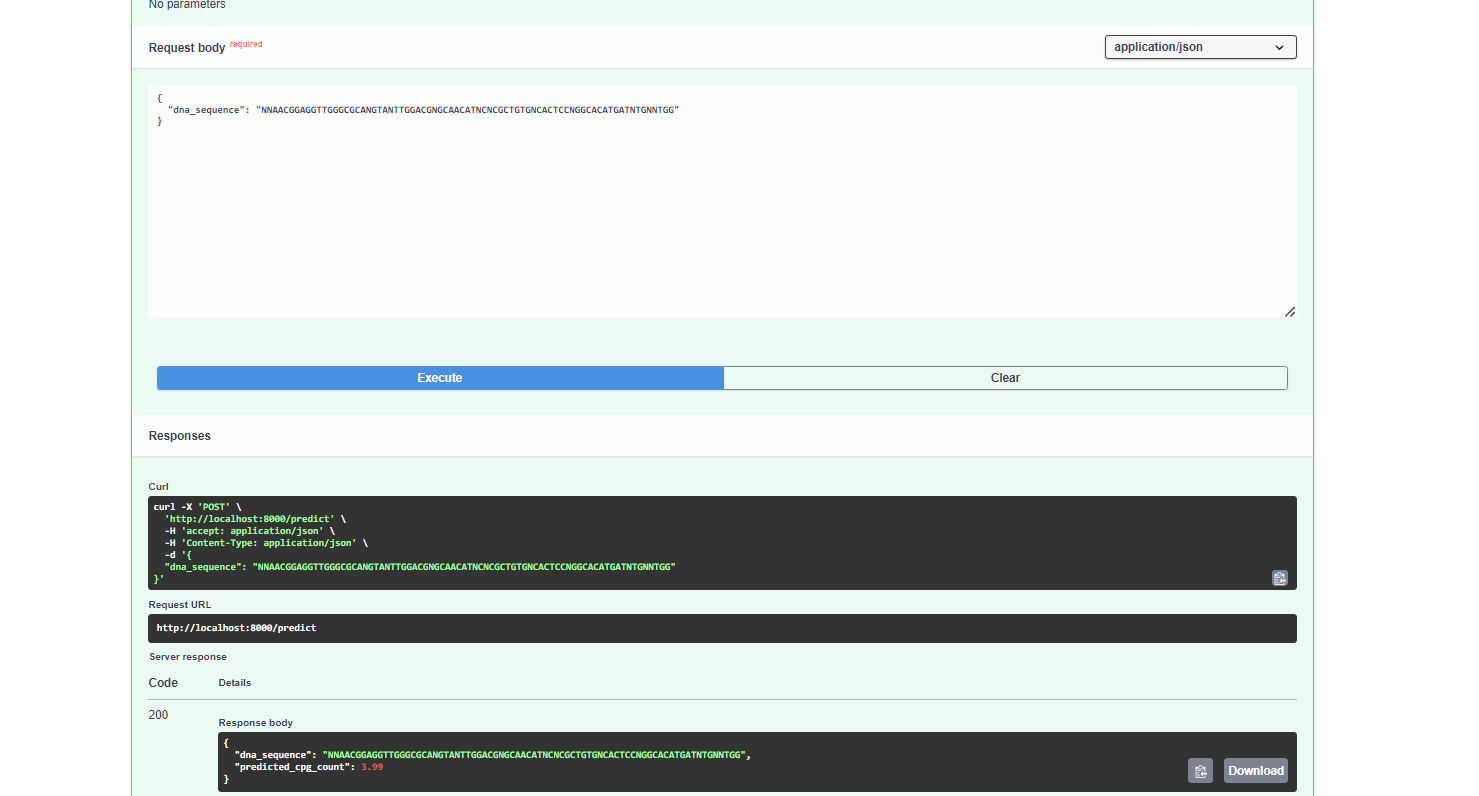

############################################################### END ####################################################################